<img src='./figures/logo_univ_lorraine.jpg' style='position:absolute; top:0; right:0;' width='150px' height='' alt='' />
<img src='./figures/logo_mines.png' style='position:absolute; top:0; left:0;' width='150px' height='' alt='' />

<p style="margin-bottom:3cm;" \p>

<center><h1 style="margin-bottom:1cm;"> Analyse de données communales </h1></center>

<center><b> Test technique Geoptis </b></center>
<center> Elkaroumi Souhayal </center>

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Introduction</h2>
</div>


Dans le cadre de ce test technique pour Geoptis, l'objectif est d'explorer un jeu de données complexe regroupant diverses variables socio-économiques et géographiques au niveau communal. Au cœur de cette étude se trouve le loyer moyen, indicateur clé de l'attractivité d'un territoire.

**Problématique:**

Comment se structurent les prix des loyers sur le territoire français et dans quelle mesure ces tarifs sont-ils corrélés à la précarité des populations locales ? 

In [1]:
# Import des librairies
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 1 – Chargement des données & création du code commune INSEE</h2>
</div>

Pour débuter ce test, j'ai procédé au chargement du jeu de données. Le fichier étant au format RDS (format natif du langage R), j'ai d'abord tenté une lecture directe en Python via la librairie `pyreadr`. Cependant, une erreur de lecture est survenue, signalant une méthode de compression du fichier non supportée par cette bibliothèque.

Face à ce problème, j'ai d'abord envisagé une conversion en `CSV`. J'ai toutefois rapidement constaté que ce format n'était pas adapté : la variable géospatiale `geometry` (polygones complexes) générait des erreurs de segmentation lors de l'importation (les coordonnées débordaient sur les autres colonnes).

Pour garantir l'intégrité des données, j'ai donc opté pour un export au format `GeoJSON`. Ce format est idéal pour conserver la structure des objets géométriques. J'ai ensuite utilisé la bibliothèque `GeoPandas` en Python, pour charger et manipuler ce jeu de données de manière plus robuste.

In [2]:
data_path = 'data/data_geoptis.geojson'
df_raw = gpd.read_file(data_path)

Nous allons conserver une copie du jeu de données brut (`df_raw`) afin de garantir la traçabilité et la reproductibilité du processus de nettoyage. Toutes les transformations sont appliquées sur une copie de travail (`df`).

In [3]:
df = df_raw.copy()

In [4]:
# Visualisation des premières lignes
df.head()

,GML_ID,ID,INSEE_ARR,an,NOM,DEP,uName,ARR,apl,typologie_urbain_rural,...,pollution_air,part_innond,eau_non_conform_par_test,part_surfbio_surfagri,manque_amenite,EPCI,capacite_touristique,codification_commune,Nombre_de_personnes_pauvres_60,geometry
0,commune.28350,COMMUNE_0000000009750236,2,2024,L'Abergement-Clémenciat,1,ABERGEMENT CLEMENCIAT,012,1.884,rural autonome peu dense,...,x,x,-99999.0,99999999.0,999999999.0,200069193,0.387145,1.0,47.0,"MULTIPOLYGON (((4.95825 46.15334, 4.9581 46.15..."
1,commune.29780,COMMUNE_0000000009750692,1,2024,L'Abergement-de-Varey,1,ABERGEMENT DE VAREY,011,2.595,rural autonome très peu dense,...,x,x,-99999.0,99999999.0,999999999.0,240100883,0.163175,2.0,16.0,"MULTIPOLYGON (((5.43369 45.98393, 5.43441 45.9..."
2,commune.131,COMMUNE_0000000009750944,1,2024,Ambérieu-en-Bugey,1,AMBERIEU EN BUGEY,011,3.629,urbain densité intermédiaire,...,x,x,-99999.0,99999999.0,999999999.0,240100883,0.078260,4.0,2644.0,"MULTIPOLYGON (((5.40942 45.94592, 5.40949 45.9..."
3,commune.33690,COMMUNE_0000000009750958,2,2024,Ambérieux-en-Dombes,1,AMBERIEUX EN DOMBES,012,3.941,rural sous faible influence d'un pôle,...,x,x,-99999.0,99999999.0,999999999.0,200042497,0.282185,5.0,133.0,"MULTIPOLYGON (((4.94292 45.97974, 4.94275 45.9..."
4,commune.31915,COMMUNE_0000000009751732,1,2024,Ambléon,1,AMBLEON,011,0.929,rural autonome très peu dense,...,x,x,-99999.0,99999999.0,999999999.0,200040350,0.020200,6.0,9.0,"MULTIPOLYGON (((5.57088 45.75316, 5.57187 45.7..."


En France, chaque commune a un Code INSEE unique composé de 5 chiffres : les 2 premiers représentent le département et les 3 suivants représentent le code de la commune au sein de ce département.

Cette clé unique revêt une importance cruciale pour les éventuelles jointures cartographiques. Il importe donc de la reconstituer avec rigueur dans notre base de données.

Nous constatons dans le jeu de données que la variable `codification_commune` est traitée comme un nombre, ce qui risque de supprimer les zéros initiaux. En la normalisant et en la combinant avec le code département (`DEP`), nous avons reconstitué la variable `Code Commune` au format texte standardisé.

In [5]:
# Ajout des zéros devant les codes
df['DEP'] = df['DEP'].astype(str).str.zfill(2)
df['codification_commune'] = df['codification_commune'].astype(float).astype(int).astype(str).str.zfill(3)

# Fusion des deux codes
df['Code Commune'] = df['DEP'] + df['codification_commune']

# Vérification
print(df[['NOM', 'DEP', 'codification_commune', 'Code Commune']].head())

                       NOM DEP codification_commune Code Commune
0  L'Abergement-Clémenciat  01                  001        01001
1    L'Abergement-de-Varey  01                  002        01002
2        Ambérieu-en-Bugey  01                  004        01004
3      Ambérieux-en-Dombes  01                  005        01005
4                  Ambléon  01                  006        01006


On peut vérifier l'exactitude de ces codes communes sur le site officiel de l'INSEE.

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 2 & 5 – Identification et nettoyage des bizarreries</h2>
</div>

Au prmier abord, le jeu de données révèle la présence de valeurs dites 'sentinelles' (comme -99999 ou 99999999). Ces valeurs ne représentent pas une réalité physique mais signalent une absence de donnée. Pour ne pas fausser les futurs calculs (moyennes, écarts-types), j'ai neutralisé ces valeurs en les remplaçant par NaN (Not a Number).

In [6]:
# Informations sur le DataFrame
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34855 entries, 0 to 34854
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   GML_ID                             34855 non-null  object  
 1   ID                                 34855 non-null  object  
 2   INSEE_ARR                          34810 non-null  object  
 3   an                                 34855 non-null  object  
 4   NOM                                34855 non-null  object  
 5   DEP                                34855 non-null  object  
 6   uName                              34855 non-null  object  
 7   ARR                                34855 non-null  object  
 8   apl                                34855 non-null  float64 
 9   typologie_urbain_rural             34855 non-null  object  
 10  Population                         34855 non-null  float64 
 11  nb_asso                          

A l'aide de cette commande, nous révèlons plusieurs anormalités dans la structure :

- Plusieurs variables supposées numériques comme `score_effort_ls_3ans` et `score_effort_ls_3ans` sont stockées sous forme de texte et contiennent des caractères spéciaux comme 'x' et 'xy'.

- Trois variables sont quasi vides (`nb_etab_quali_tourist_handi`, `SDP_AUT`, `nb_prg_anah`) avec moins de $1$% de valeurs présentes. Un pourcentage très faible qui rend ces variables inexploitables statistiquement à l'échelle nationale.

- la présence de colonnes contenant probablement des valeurs sentinelles (-99999).



In [7]:
# Liste des colonnes numériques qui contiennent potentiellement des anormalitées
cols_numeriques_suspectes = [
    'part_bonne_dpe_lgt_soc', 'eau_non_conform_par_test',
    'part_surfbio_surfagri', 'manque_amenite'
]

In [8]:
# On définit la liste complète des bizzareries détectées sur les colonnes de type 'object'
liste_bizzarerie = ['x', 'xy', 'y', '-999999', '-8888']
# '-8888' est présente 3 fois dans la variable 'DEP' alors que '-999999' est présente dans plusieurs autres variables

# On applique le remplacement par NaN sur tout le DataFrame
df = df.replace(liste_bizzarerie, np.nan)

# On identifie les colonnes numériques
cols_num = df.select_dtypes(include=[np.number]).columns

for col in cols_num:
    # On traite les négatifs (tous à NaN car impossible dans notre cas)
    df.loc[df[col] < 0, col] = np.nan
    
    # On traite les maximums délirants
    if col == 'loyer_moyen':
        df.loc[df[col] > 100000, col] = np.nan
    if col == 'part_abstention_legislatives_2022':
        df.loc[df[col] > 1, col] = np.nan # Une probabilité est inférieure à 1

for col in cols_numeriques_suspectes :
    # On régle les sentinelles (ex : float(99999))
    df.loc[df[col] > 10000, col] = np.nan

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_27284\2435645543.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(liste_bizzarerie, np.nan)


In [9]:
# Visualisation d'un échantillon des données nettoyées
df.sample(10)

,GML_ID,ID,INSEE_ARR,an,NOM,DEP,uName,ARR,apl,typologie_urbain_rural,...,part_innond,eau_non_conform_par_test,part_surfbio_surfagri,manque_amenite,EPCI,capacite_touristique,codification_commune,Nombre_de_personnes_pauvres_60,geometry,Code Commune
4935,commune.20230,COMMUNE_0000000009731851,1,2024,Vierville-sur-Mer,14,VIERVILLE SUR MER,141,2.797,rural autonome très peu dense,...,NaN,NaN,NaN,NaN,200066801,5.446708,745,20.0,"MULTIPOLYGON (((-0.88225 49.3718, -0.88314 49....",14745
5677,commune.28749,COMMUNE_0000000009752176,4,2024,Courcoury,17,COURCOURY,174,4.160,rural sous forte influence d'un pôle,...,NaN,NaN,NaN,NaN,200036473,0.000000,128,53.0,"MULTIPOLYGON (((-0.54209 45.68062, -0.54202 45...",17128
22451,commune.7413,COMMUNE_0000000009727109,4,2024,Zuytpeene,59,ZUYTPEENE,594,4.018,rural autonome peu dense,...,NaN,NaN,NaN,NaN,200040947,0.543865,669,47.0,"MULTIPOLYGON (((2.45531 50.80182, 2.45531 50.8...",59669
11121,commune.7924,COMMUNE_0000000009757801,1,2024,Rousson,30,ROUSSON,301,2.931,urbain densité intermédiaire,...,NaN,NaN,NaN,NaN,200066918,0.000000,223,532.0,"MULTIPOLYGON (((4.20143 44.17994, 4.20137 44.1...",30223
7659,commune.24190,COMMUNE_0000000009749858,2,2024,Le Bourg-d'Hem,23,BOURG D HEM,232,2.180,rural autonome très peu dense,...,NaN,NaN,NaN,NaN,242320109,0.667474,029,34.0,"MULTIPOLYGON (((1.82735 46.28397, 1.82767 46.2...",23029
18873,commune.25150,COMMUNE_0000000301057045,2,2024,Chézeaux,52,CHEZEAUX,522,1.969,rural autonome très peu dense,...,NaN,NaN,NaN,NaN,200070332,0.359312,124,10.0,"MULTIPOLYGON (((5.67683 47.87038, 5.67714 47.8...",52124
27359,commune.10892,COMMUNE_0000000009744191,2,2024,Brotte-lès-Ray,70,BROTTE LES RAY,702,2.450,rural autonome très peu dense,...,NaN,NaN,NaN,NaN,247000623,0.495839,099,7.0,"MULTIPOLYGON (((5.76611 47.61211, 5.76534 47.6...",70099
31905,commune.33532,COMMUNE_0000000009758380,1,2024,Labastide-Gabausse,81,LABASTIDE GABAUSSE,811,2.910,rural sous forte influence d'un pôle,...,NaN,NaN,NaN,NaN,200040905,0.000000,114,39.0,"MULTIPOLYGON (((2.10115 44.0158, 2.1014 44.015...",81114
27360,commune.8914,COMMUNE_0000000009744757,2,2024,Broye-les-Loups-et-Verfontaine,70,BROYE LES LOUPS ET VERFONTAINE,702,2.212,rural autonome très peu dense,...,NaN,NaN,NaN,NaN,200036549,0.000000,100,24.0,"MULTIPOLYGON (((5.43628 47.49048, 5.43596 47.4...",70100
21716,commune.15116,COMMUNE_0000000009747727,3,2024,Saincaize-Meauce,58,SAINCAIZE MEAUCE,583,1.659,rural sous forte influence d'un pôle,...,NaN,NaN,NaN,NaN,245804406,0.911480,225,46.0,"MULTIPOLYGON (((3.06458 46.88944, 3.06608 46.8...",58225


Enfin, nous vérifions les doublans dans la base de donnée car si une commune est présente deux fois, les statistiques (moyennes, totaux) seront faussées.

In [10]:
# Calcul du nombre de doublons basés sur la colonne 'Code Commune'
nb_doublons = df.duplicated(subset=['Code Commune'], keep=False).sum()
print(f"Nombre de communes en doublon : {nb_doublons}")

Nombre de communes en doublon : 25


Une visualtion des colonnes de ces doublons a permis de détecter qu'il s'agit de la même commune (31555) répétée 25 fois. Nous conservons donc uniquement la première occurence.

In [11]:
# Suppression des doublons en gardant la première occurrence
if nb_doublons > 0:
    df = df.drop_duplicates(subset=['Code Commune'], keep='first')

On supprime également les éventuelles colonnes vides après le nettoyage.

In [12]:
# Suppression des colonnes entièrement vides
df = df.dropna(axis=1, how='all')

Nous voudrons également nous assurer que la variable géométrique est bien représenté dans notre jeu de données.

In [13]:
# Vérifier la géométrie
nb_geometries_nulles = df['geometry'].isna().sum()
nb_geometries_invalides = (~df['geometry'].is_valid).sum()

print(f"Géométries manquantes : {nb_geometries_nulles}")
print(f"Géométries invalides : {nb_geometries_invalides}")

Géométries manquantes : 0
Géométries invalides : 0


<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 3 – Dimensions du dataset et résumé statistique global</h2>
</div>

Après le nettoyage des doublons et l'ajout de notre clé primaire `Code Commune`, nous pouvons tirer plus de conclusions initiales de notre base de donnée.

In [14]:
# taille du DataFrame final
df.shape

(34831, 26)

Après nettoyage des doublons, notre jeu de données final est composé de $34 831$ lignes et $26$ colonnes. Chaque ligne correspond à une commune française unique.

À titre de comparaison, le recensement officiel de l'Insee au 1er janvier 2025 dénombre $34 874$ communes ($34 745$ en métropole et $129$ dans les DROM). Notre dataset couvre donc environ $99,8$% du territoire national, ce qui garantit une représentativité quasi exhaustive pour notre analyse statistique et cartographique.

Durant l'étape de nettoyage nous avons effacé $24$ lignes et $16$ colonnes qui contenaient au départ des valeurs aberrantes ou manquantes.

In [15]:
# Statistiques globales
resume_stat_global = df.describe().T

print(resume_stat_global[['count', 'mean', 'std', 'min', '50%', 'max']])

                                     count         mean          std  \
apl                                34707.0     3.004199     1.290864   
Population                         34831.0  1899.195602  8793.440896   
nb_asso                            34707.0     0.038542     0.017451   
segregation_locale                 34707.0     0.206793     0.060540   
part_abstention_legislatives_2022  34707.0     0.457177     0.079498   
terrain_a_valoriser                34707.0     0.009358     0.032517   
nb_etab_quali_tourist              34707.0     0.006073     0.023982   
loyer_moyen                        34706.0   711.702403   162.139675   
part_logement_secondaire           34707.0     0.253208     0.639802   
indice_feu_foret                   34707.0    11.772866     4.922983   
capacite_touristique               34831.0     0.658464     2.276951   
Nombre_de_personnes_pauvres_60     34707.0   285.771689  1929.388179   

                                        min         50%        

**Analyse statistique globale**

On observe de légères variations dans le décompte (count) des variables. La population couvre l'intégralité du dataset ($34 831$), tandis que d'autres indicateurs (loyer, associations) se stabilisent à $34 707$ unités. Ce delta de $124$ communes correspond aux entités pour lesquelles les données n'ont pas été collectées ou jugées non significatives.

Le nettoyage des données a permis enfin de dégager un portrait cohérent des communes françaises de notre échantillon.

- **Démographie & Social** : En moyenne une commune compte environ $1 900$ habitants, mais la médiane à $456$ souligne la prédominance des petites communes rurales. On observe une réelle hétérogénéité sociale avec un nombre de personnes pauvres ayant des revenus inférieurs à 60% de la médiane allant de $0$ à plus de $112 000$ pour les plus grandes métropoles.

- **Logement** : Le loyer mensuel moyen s'établit autour de $711 €$, avec une distribution resserrée (un écart type de $160 €$) et avec un loyer maximum autour de $2000€$. En outre, Le secteur immobilier est marqué par une présence non négligeable de résidences secondaires (moyenne de $25$%).

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 4 - Résumé statistique des colonnes sélectionnées</h2>
</div>

In [16]:
# Liste des colonnes demandées
colonnes_focus = [
    "apl", "typologie_urbain_rural", "nb_asso", "segregation_locale",
    "Nombre_de_personnes_pauvres_60", "part_logement_secondaire", 
    "part_abstention_legislatives_2022", "terrain_a_valoriser",
    "nb_etab_quali_tourist", "loyer_moyen", "indice_feu_foret", "capacite_touristique"
]

# Résumé statistique
resume_focus = df[colonnes_focus].describe(include='all').T

resume_focus

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
apl,34707.0,NaN,NaN,NaN,3.004199,1.290864,0.0,2.18,2.935,3.733,28.746
typologie_urbain_rural,34831,6,rural autonome très peu dense,8085,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nb_asso,34707.0,NaN,NaN,NaN,0.038542,0.017451,0.0,0.027525,0.034463,0.045012,0.534626
segregation_locale,34707.0,NaN,NaN,NaN,0.206793,0.06054,0.00498,0.167183,0.203467,0.242817,0.575283
Nombre_de_personnes_pauvres_60,34707.0,NaN,NaN,NaN,285.771689,1929.388179,0.0,19.0,42.0,105.0,112570.0
part_logement_secondaire,34707.0,NaN,NaN,NaN,0.253208,0.639802,0.0,0.030317,0.085708,0.242856,38.222222
part_abstention_legislatives_2022,34707.0,NaN,NaN,NaN,0.457177,0.079498,0.0,0.411883,0.463918,0.51,0.78125
terrain_a_valoriser,34707.0,NaN,NaN,NaN,0.009358,0.032517,0.0,0.000056,0.000881,0.005479,0.799319
nb_etab_quali_tourist,34707.0,NaN,NaN,NaN,0.006073,0.023982,0.0,0.0,0.001168,0.006148,1.428571
loyer_moyen,34706.0,NaN,NaN,NaN,711.702403,162.139675,0.0,602.015326,694.674101,801.180652,2064.254464


Cette partie a pour but d'affiner la description statistique précédente notamment en ajoutant une variable typologique `typologie_urbain_rural`. Nous observons que la France rurale est la plus représentée avec une majorité de communes classées en "rural autonome très peu dense" ($8 085$ communes).

- **Santé** : Selon l'INSEE, l'indicateur d'accessibilité potentielle localisée (variable `apl`) est un indicateur d'adéquation territoriale entre l'offre et la demande de soins de ville (hors hôpital). Il permet de mesurer à la fois la proximité et la disponibilité des professionnels de santé.
Selon notre analyse statistique, la population a accès en moyenne à $3$ consultations par an chez le médecin généraliste.


- **Engagement & Citoyenneté** : les associations dont dynamiques (environ $38$ associations pour $1 000$ habitants), bien que l'abstention aux législatives de 2022 reste élevée avec une moyenne nationale de $45,7$%.

- **Environnement** : L'indice de feu de forêt présente une variabilité intéressante (moyenne de $11,7$), reflétant les disparités climatiques et géographiques du territoire.

- **Tourisme** : D'après la définition de l'INSEE la *capacité touristique* correspond à un indicateur de capacité d’accueil touristique de la commune. Il s’agit d’un indicateur normalisé permettant de comparer les communes indépendamment de leur taille démographique. On note une capacité touristique très hétérogène (de $0$ à $121$), confirmant que l'activité est concentrée sur des pôles spécifiques.

- **segregation_locale** : Cet indice mesure la séparation entre les différentes classes sociales au sein de la commune (0 : mixité parfaite, 1 : ségrégation totale). On remarque que la moyenne est de $0.20$. La France se situe donc dans une ségrégation modérée en moyenne. La médiane à $0.20$ montre une homogénéité nationale, mais le max à $0.57$ indique des villes où les clivages sont très marqués.

NB : Les définitions des indicateurs proviennent du site de l'INSEE.

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 6 – Export du dataset nettoyé en CSV</h2>
</div>

À ce stade, grâce à l'analyse exploratoire combinant diagnostics quantitatif et qualitatif ainsi qu'une étude statistique ciblée, notre jeu de données est nettoyé de ses valeurs aberrantes et sentinelles. Le dataset est désormais intègre, cohérent et prêt pour l'export au format CSV.

In [17]:
# Informations sur le DataFrame
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34831 entries, 0 to 34854
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   GML_ID                             34831 non-null  object  
 1   ID                                 34831 non-null  object  
 2   INSEE_ARR                          34786 non-null  object  
 3   an                                 34831 non-null  object  
 4   NOM                                34831 non-null  object  
 5   DEP                                34828 non-null  object  
 6   uName                              34831 non-null  object  
 7   ARR                                34831 non-null  object  
 8   apl                                34707 non-null  float64 
 9   typologie_urbain_rural             34831 non-null  object  
 10  Population                         34831 non-null  float64 
 11  nb_asso                            347

On remarque qu'effectivement la dataset est "clean".

In [18]:
# Nom du fichier de sortie
export_path = 'data/communes_france_nettoye.csv'

# Exportation en CSV
df.to_csv(export_path, index=False, sep=';', encoding='utf-8-sig')

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 7 – Suppression des départements d’Outre-Mer et de Corse</h2>
</div>

En France, les codes départements fonctionnent ainsi :

- Corse : 2A et 2B. La Corse comporte 360 communes [chiffre du site officiel du ministère de la culture].

- DROM (Départements et Régions d'Outre-Mer) : commencent par 97 (971, 972, 973, 974, 976).

- Métropole (hors Corse) : tout le reste (01 à 95).

In [19]:
# Liste des départements à exclure
dep_a_exclure = ['2A', '2B', '97']

# Filtrage : on ne garde que les départements qui ne sont pas dans la liste
df_metropole = df[~df['DEP'].isin(dep_a_exclure)].copy()

# Rapport de suppression
print(f"Communes avant filtrage : {len(df)}")
print(f"Communes après filtrage (France continentale) : {len(df_metropole)}")
print(f"Total supprimé : {len(df) - len(df_metropole)}")

Communes avant filtrage : 34831
Communes après filtrage (France continentale) : 34471
Total supprimé : 360


Probablement, les communes supprimées correspondent toutes à la Corse et la dataset ne contient donc pas les données afférentes aux départments d'Outre-Mer. Ceci explique également le décalage observé lors de la comparaison du nombre total de communes françaises avec celles présentes dans notre échantillon.

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 8 – Tableau statistique global et focus Haute-Garonne</h2>
</div>

In [20]:
# Fonction pour générer le tableau croisé
def synthese_loyers(data):
    return data.groupby('typologie_urbain_rural')['loyer_moyen'].agg(
        Moyenne='mean',
        Mediane='median'
    )

# Tableau 1 : France Continentale
tableau_france = synthese_loyers(df_metropole)

print("--- Synthèse France Continentale ---")
print(tableau_france)

--- Synthèse France Continentale ---
                                          Moyenne     Mediane
typologie_urbain_rural                                       
rural autonome peu dense               665.189728  650.232987
rural autonome très peu dense          631.457590  618.700783
rural sous faible influence d'un pôle  732.818704  714.194147
rural sous forte influence d'un pôle   775.966885  760.897386
urbain dense                           868.104867  853.130851
urbain densité intermédiaire           795.462499  778.281881


Ce tableau illustre parfaitement la hiérarchie des loyers en France : plus on se rapproche des grands métropoles et de la densité urbaine, plus la facture augmente. On observe un saut net de $236 €$ entre un milieu rural très peu dense et un milieu urbain dense, confirmant que la proximité des services et des pôles d'emploi reste le principal moteur des prix. On remarque également une cohérence entre les moyennes et les médianes.

In [21]:
# Tableau 2 : Haute-Garonne uniquement (Code DEP = 31)
df_31 = df_metropole[df_metropole['DEP'] == '31']
tableau_31 = synthese_loyers(df_31)

print("\n--- Synthèse Haute-Garonne (31) ---")
print(tableau_31)


--- Synthèse Haute-Garonne (31) ---
                                          Moyenne     Mediane
typologie_urbain_rural                                       
rural autonome peu dense               668.362341  662.271696
rural autonome très peu dense          670.225918  682.383330
rural sous faible influence d'un pôle  746.708922  730.074734
rural sous forte influence d'un pôle   863.936396  844.000354
urbain dense                           780.458117  780.497199
urbain densité intermédiaire           820.021044  802.425684


En Haute-Garonne, le décor change : la hiérarchie classique est bousculée par la force d'attraction de la métropole toulousaine. Le fait marquant est ici le prix du "rural sous forte influence d'un pôle" ($864 €$), qui dépasse même l'urbain dense ($780€$). En Haute-Garonne, même les zones rurales peuvent afficher des loyers plus élevés qu'ailleurs en France à cause du dynamisme de l'aire aéronautique.

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 9 – Visualisations comparatives</h2>
</div>

<h3 style="border-left: 5px solid #4aa3ff; padding-left: 10px; margin-top:25px;">
    Histogramme des loyers
</h3>

Cette étape est cruciale d'une part pour valider visuellement tout le travail de nettoyage que nous avons fait. D'autre part, l'histogramme permet de confirmer que la distribution des loyers est naturelle et suit une courbe en cloche.

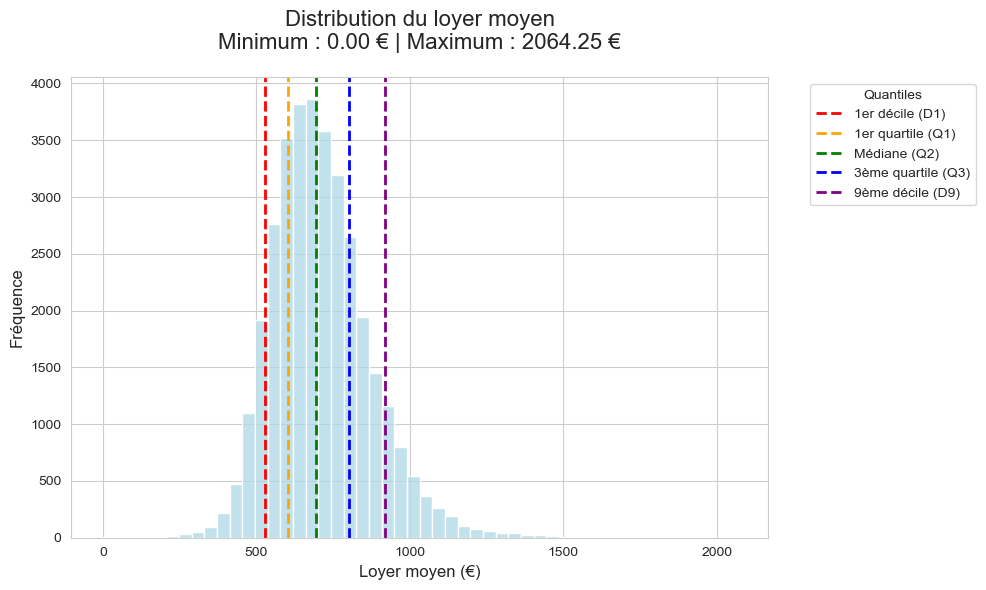

In [22]:
# Configuration du style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Création de l'histogramme
ax = sns.histplot(df_metropole['loyer_moyen'], bins=50, color='lightblue', edgecolor='white')

# Ajout des lignes verticales pour les quantiles
quantiles = df_metropole['loyer_moyen'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
colors = ['red', 'orange', 'green', 'blue', 'purple']
labels = ['1er décile (D1)', '1er quartile (Q1)', 'Médiane (Q2)', '3ème quartile (Q3)', '9ème décile (D9)']

for q, color, label in zip(quantiles, colors, labels):
    plt.axvline(q, color=color, linestyle='--', linewidth=2, label=label)

# Titres et étiquettes
plt.title(f"Distribution du loyer moyen\nMinimum : {df_metropole['loyer_moyen'].min():.2f} € | Maximum : {df_metropole['loyer_moyen'].max():.2f} €", 
          fontsize=16, pad=20)
plt.xlabel("Loyer moyen (€)", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)

# Placement de la légende
plt.legend(title="Quantiles", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

La visualisation de la distribution confirme la qualité du traitement de données. L'histogramme révèle une distribution unimodale centrée autour de $700 €$, avec une queue de distribution s'étendant jusqu'à $2 064 €$ pour les zones les plus tendues. 

Le positionnement des déciles et quartiles souligne la forte concentration des loyers dans une fourchette étroite ($500 €$ - $900 €$), tandis que l'absence de valeurs isolées à l'extrême droite valide l'élimination réussie des données sentinelles.

<h3 style="border-left: 5px solid #4aa3ff; padding-left: 10px; margin-top:25px;">
    Boxplot du loyer moyen
</h3>

Dans le même cadre du logement, nous construisons un boxplot (boîte à moustaches) pour traquer les valeurs extrêmes ainsi que la fourchette où se situent la majorité des loyers.

**Rappel :**

Le boxplot (ou boîte à moustaches) est un outil graphique qui permet de résumer la distribution d'une variable. La boîte centrale représente les $50$% centraux des données. Elle est délimitée par le 1er quartile ($Q1$) en bas et le 3ème quartile ($Q3$) en haut.La ligne médiane : Elle coupe la boîte en deux et indique la valeur qui sépare l'échantillon en deux groupes égaux. Les "moustaches" sont les traits qui s'étendent au-dessus et en dessous de la boîte indiquent la variabilité des données (généralement jusqu'à $1.5 \times \text{l'écart interquartile}$). Les points isolés ou outliers sont tous les points situés au-delà des moustaches et sont considérés comme des valeurs atypiques.

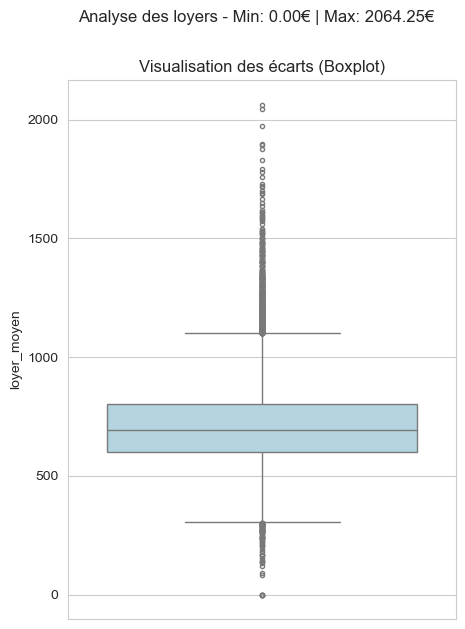

In [23]:
# Configuration du style
plt.figure(figsize=(5, 7))
sns.set_style("whitegrid")

# Le Boxplot
sns.boxplot(y=df_metropole['loyer_moyen'], color='lightblue', fliersize=3)
plt.title("Visualisation des écarts (Boxplot)")

plt.suptitle(f"Analyse des loyers - Min: {df_metropole['loyer_moyen'].min():.2f}€ | Max: {df_metropole['loyer_moyen'].max():.2f}€")
plt.show()

Ces graphiques nous racontent l'histoire d'un marché immobilier français à deux vitesses. L'histogramme montre que pour une immense majorité de communes, le loyer moyen se situe dans une fourchette entre $600 €$ et $800 €$ (la zone dense entre Q1 et Q3).

Cependant, le boxplot révèle la face cachée : une multitude de points s'échappent vers le haut, illustrant ces communes hors normes (souvent en Île-de-France ou sur la Côte d'Azur) où les prix s'envolent jusqu'à doubler la moyenne nationale.

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 10 – Visualisation supplémentaire</h2>
</div>

Similairement au boxplot le **Violin Plot** (diagramme en violon) est une version du Boxplot, il montre non seulement les quartiles, mais aussi la densité des données. La partie où le violon est le plus large, c'est là où se trouvent la majorité des communes.

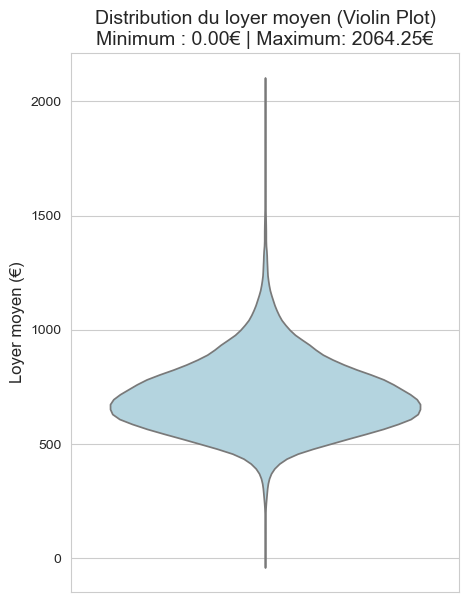

In [24]:
# Configuration de la figure
plt.figure(figsize=(5, 7))
sns.set_style("whitegrid")

# Création du Violin Plot
ax = sns.violinplot(y=df_metropole['loyer_moyen'], color="lightblue", inner=None)

# Titre et labels
plt.title(f"Distribution du loyer moyen (Violin Plot)\nMinimum : {df_metropole['loyer_moyen'].min():.2f}€ | Maximum: {df_metropole['loyer_moyen'].max():.2f}€", fontsize=14)
plt.ylabel("Loyer moyen (€)", fontsize=12)

plt.show()

Le Violin Plot nous offre une lecture plus riche du marché locatif que le boxplot. Sa forme évasé vers le bas confirme visuellement ce que nous pressentions : une très forte concentration des communes françaises dans une zone de prix modérés (entre $500 €$ et $800 €$). Le long col qui s'étire vers le haut représente cette minorité de villes aux loyers d'exception.

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 11 – Visualisation géographique avancée</h2>
</div>

La Nouvelle-Aquitaine comprend 12 départements.

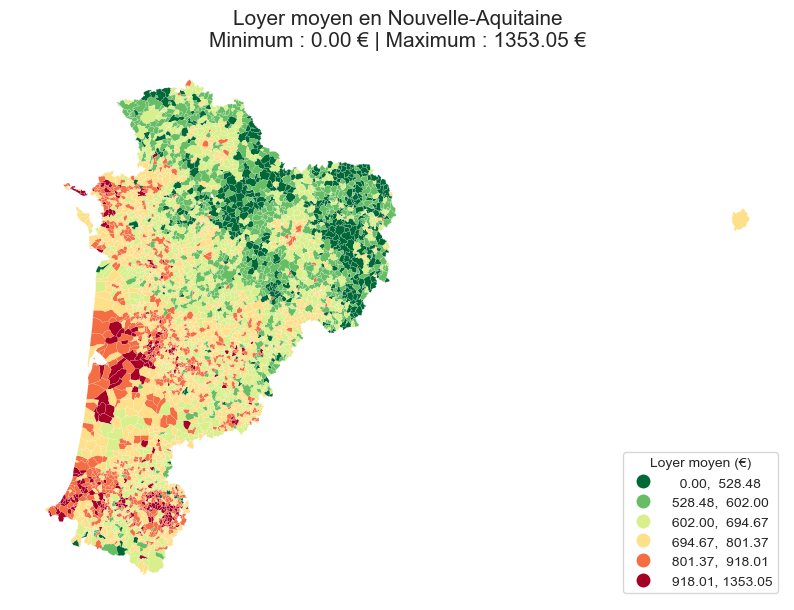

In [25]:
# Filtrer selon la Nouvelle-Aquitaine
df_na = df_metropole[df_metropole['DEP'].isin(['16', '17', '19', '23', '24', '33', '40', '47', '64', '79', '86', '87'])].copy()

# Définir les seuils basées sur les quantiles (D1, Q1, Q2, Q3, D9)
bins = [df_metropole['loyer_moyen'].min()-1, 
        quantiles[0.1], quantiles[0.25], quantiles[0.5], 
        quantiles[0.75], quantiles[0.9], df_metropole['loyer_moyen'].max()]

labels = ['min-D1', 'D1-Q1', 'Q1-Q2', 'Q2-Q3', 'Q3-D9', 'D9-max']

# Création de la figure
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Affichage de la carte
df_na.plot(column='loyer_moyen', 
           scheme='UserDefined', 
           classification_kwds={'bins': bins[1:-1]},
           cmap='RdYlGn_r',
           edgecolor='white',
           linewidth=0.08,
           legend=True,
           legend_kwds={'title': "Loyer moyen (€)", 'loc': 'lower right'},
           ax=ax)

ax.set_axis_off()
plt.title(f"Loyer moyen en Nouvelle-Aquitaine\nMinimum : {df_na['loyer_moyen'].min():.2f} € | Maximum : {df_na['loyer_moyen'].max():.2f} €", fontsize=15)

plt.show()

La carte révèle une géographie des prix très contrastée en Nouvelle-Aquitaine. On distingue nettement deux pôles de tension immobilière (en rouge/orange) : le littoral atlantique, très prisé, et l'agglomération bordelaise. À l'inverse, l'intérieur des terres (Creuse, Corrèze, nord de la Haute-Vienne) affiche des loyers situés dans les premiers déciles (en vert), illustrant la diagonale du vide et une pression locative bien moindre. Cette visualisation confirme que le loyer moyen n'est pas qu'une question de densité, mais aussi de proximité avec l'océan et les grands centres de décision.

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Étape 12 – Relation entre loyer moyen et pauvreté</h2>
</div>

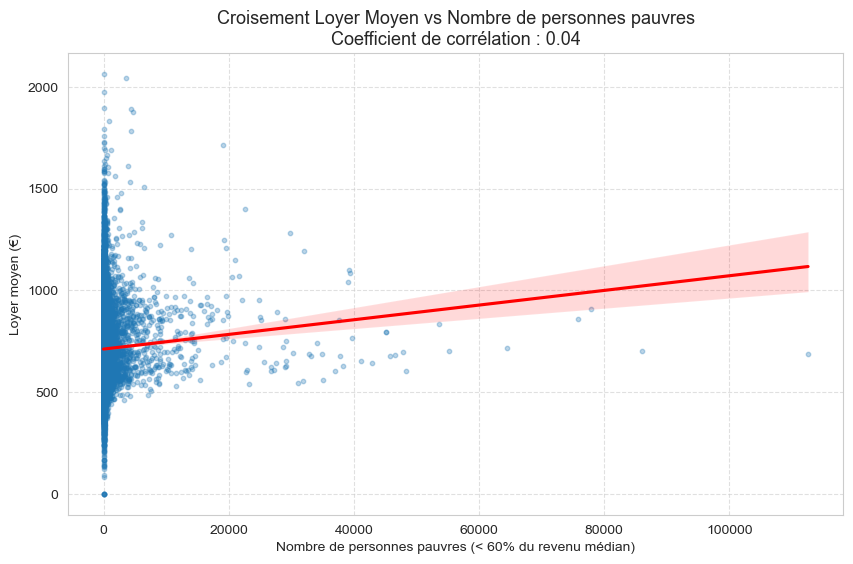

In [26]:
# Calcul de la corrélation
correlation = df_metropole['loyer_moyen'].corr(df_metropole['Nombre_de_personnes_pauvres_60'])

# Création du graphique
plt.figure(figsize=(10, 6))
sns.regplot(data=df_metropole, 
            x='Nombre_de_personnes_pauvres_60', 
            y='loyer_moyen',
            scatter_kws={'alpha':0.3, 's':10}, 
            line_kws={'color':'red'})

plt.title(f"Croisement Loyer Moyen vs Nombre de personnes pauvres\nCoefficient de corrélation : {correlation:.2f}", fontsize=13)
plt.xlabel("Nombre de personnes pauvres (< 60% du revenu médian)")
plt.ylabel("Loyer moyen (€)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

**Analyse du croisement Loyer vs Pauvreté:**

Tout d'abord, nous observons une corrélation quasi nulle ($0.04$). Ce chiffre confirme qu'il n'existe aucune relation linéaire entre le nombre de personnes pauvres et le niveau du loyer moyen au niveau des communes. En clair, savoir qu'une commune compte beaucoup de personnes pauvres ne permet absolument pas de prédire si les loyers y seront hauts ou bas. Ensuite, on observe une énorme concentration de points sur la gauche (près de zéro). Cela correspond à l'immense majorité des petites communes françaises qui ont un faible nombre d'habitants, et donc mécaniquement un faible nombre de personnes sous le seuil de pauvreté. Les valeurs atypiques (Outliers) tout à fait à droite représentent les très grandes métropoles. On y voit des villes avec plus de $100 000$ personnes pauvres mais des loyers qui restent dans la moyenne haute (autour de $700$-$1000 €$). En guise de concluion, ce graphique montre que le marché du logement ne s'auto-régule pas en fonction de la précarité des habitants. Les loyers sont dictés par l'attractivité de la zone et non par la capacité financière des populations les plus fragiles.

L'analyse brute du nombre de personnes pauvres par commune présente un biais de masse : les grandes métropoles apparaissent mécaniquement comme des foyers de pauvreté simplement car elles sont plus peuplées. Pour affiner notre diagnostic, il est indispensable de normaliser cette donnée. En observant le pourcentage de personnes pauvres par rapport à la population totale. Ce changement de perspective révèle une corrélation bien plus significative, comme le montre la figure ci-dessous.

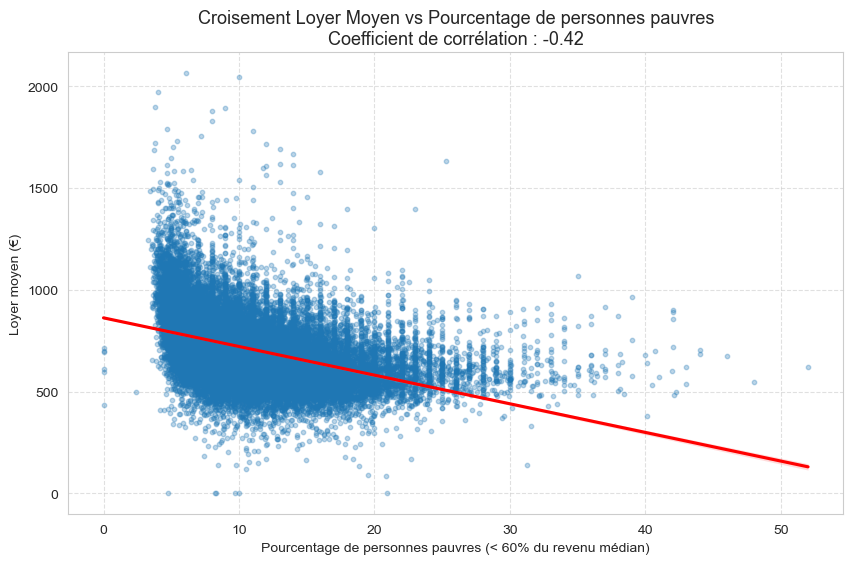

In [27]:
# Calcul de la corrélation
plot_copy = df_metropole.copy()
plot_copy['pct_pauvres_60'] = (plot_copy['Nombre_de_personnes_pauvres_60'] / plot_copy['Population']) * 100
correlation = plot_copy['loyer_moyen'].corr(plot_copy['pct_pauvres_60'])

# Création du graphique
plt.figure(figsize=(10, 6))
sns.regplot(data=plot_copy, 
            x='pct_pauvres_60', 
            y='loyer_moyen',
            scatter_kws={'alpha':0.3, 's':10}, 
            line_kws={'color':'red'})

plt.title(f"Croisement Loyer Moyen vs Pourcentage de personnes pauvres\nCoefficient de corrélation : {correlation:.2f}", fontsize=13)
plt.xlabel("Pourcentage de personnes pauvres (< 60% du revenu médian)")
plt.ylabel("Loyer moyen (€)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

Le passage à une analyse en pourcentage permet de dégager des conclusions bien plus robustes que l'étude des volumes bruts. Nous observons une corrélation négative modérée ($-0,42$). Contrairement à l'analyse précédente, nous observons ici une tendance réelle. Plus la part de la population vivant sous le seuil de pauvreté est élevée au sein d'une commune, plus le loyer moyen tend à diminuer.

Les points situés en haut à gauche du graphique représentent les communes privilégiées (faible pauvreté, loyers très élevés). À l'inverse, les points isolés au centre-haut du nuage signalent des situations critiques dans ces communes où le taux de pauvreté dépasse les $15$-$20$ % mais où les loyers restent supérieurs à $1 000 €$, exposant les habitants à un risque majeur de mal-logement.

Finalement, ce croisement de données démontre que si la géographie de la pauvreté influence le marché locatif, elle ne suffit pas à l'expliquer entièrement. D'autres variables de tension (proximité des métropoles, littoral, offre de transport) maintiennent des prix élevés, même dans des contextes sociaux fragiles.

<div style="background-color:#7f7f7f; color:white; padding:12px 15px; border-radius:5px; margin-top:35px;">
    <h2 style="margin:0;">Retour d'expérience et conclusion générale</h2>
</div>


Ce test technique a été l'occasion de traverser l'ensemble de la chaîne de valeur d'un Data Analyst/ Scientist : du chargement des données à la restitution cartographique et statistique. Voici mon bilan personnel sur ce travail.

**Répartition du temps et cheminement**

Le temps global a été réparti de manière hétérogène, reflétant la réalité du métier où la préparation des données est souvent l'étape la plus dense.

- Étape 1 (Chargement & Formatage) ~ [1h] : Cette étape a été plus longue que prévu. Le format RDS n'étant pas natif sur tous les environnements, j'ai d'abord utilisé R pour sa capacité de visualisation immédiate, ce qui m'a permis de valider l'intégrité du jeu de données dès le départ. Je suis ensuite repassé sur Geopandas (en lien avec nos échanges lors du premier entretien) pour la suite de l'étude.

- Étape 2 & 5 (Nettoyage & Valeurs aberrantes) ~ [3h] : C'est la phase la plus chronophage. J'ai fait le choix de regrouper la logique de nettoyage dès le début pour garantir un Notebook fluide. Cela a nécessité de nombreux allers-retours entre l'affichage de "samples", l'analyse des statistiques descriptives (min/max) et la compréhension métier des variables.

- Étapes 3 à 10 (Analyses Statistiques & Distribution) ~ [4h] : Une fois les données saines, l'enchaînement a été très fluide. La structure logique des étapes m'a permis de valider progressivement mes intuitions.

- Étapes 11 & 12 (Cartographie & Corrélation) ~ [1h] : Phase de restitution visuelle et de mise en perspective des données.

**Utilisation des LLM & Résolution de problèmes**

J'ai abordé ce test avec une approche pragmatique, en utilisant les outils à ma disposition pour gagner en efficacité tout en gardant le contrôle critique sur les résultats :

Pour toute la partie nettoyage, logique métier et analyses statistiques (Étapes 2 à 10), j'ai privilégié une approche manuelle basée sur mes connaissances en manipulation de données (Pandas/Numpy).

J'ai sollicité l'aide d'un LLM principalement sur l'Étape 11. La gestion des couches géographiques et des palettes de couleurs spécifiques pour la Nouvelle-Aquitaine demandait une syntaxe précise que j'ai souhaité optimiser via l'IA. J'ai également utilisé l'IA pour vérifier rapidement certaines syntaxes de commandes Python.

Cette analyse du marché locatif français au travers des données communales, met en lumière une réalité territoriale complexe. L'étude révèle une fracture nette entre les zones de "tension" (littoral, métropoles) et une France rurale. Alors que la majorité des communes françaises maintiennent des loyers accessibles (entre $500 €$ et $800 €$), les valeurs extrêmes identifiées dans le boxplot et le violin plot montrent que l'accès au logement devient un défi majeur dès que l'on se rapproche des pôles d'attractivité.

La déconnexion entre loyers et précarité reste le résultat le plus marquant de cette étude. La corrélation modérée montre que le marché immobilier possède sa propre inertie : même dans les communes où la population est la plus fragile financièrement, les loyers ne baissent pas de manière proportionnelle.

La cartographie de la Nouvelle-Aquitaine illustre parfaitement que le loyer est avant tout un indicateur d'attractivité géographique. La proximité de l'océan ou d'une métropole comme Bordeaux allongent la facture, indépendamment parfois de la composition sociale des communes.

En somme, cette étude démontre que le logement n'est pas qu'une variable économique, c'est un marqueur social profond. Comprendre ces dynamiques est essentiel pour orienter les politiques publiques de demain, afin que l'attractivité d'un territoire ne devienne pas un facteur d'exclusion pour ses habitants les plus modestes.